## Новый код


In [1]:
import requests
import osmnx as ox
import pandas as pd
import geopandas as gpd

# from shapely.geometry import shape
# from shapely.geometry import MultiPolygon
# from shapely.geometry import shape, box
# from shapely.geometry import Polygon

In [14]:
import os

# os.environ["USE_PYGEOS"] = os.environ.get("USE_PYGEOS", "0")
local_crs = 32636
# path to data
example_data_path = "./data"

In [3]:
# load aggregated info we have
aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

In [4]:
# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet")).rename_geometry('geometry')

hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson"))
pharmacies = gpd.read_file(os.path.join(example_data_path, "pharmacies.geojson"))
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson"))

# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas,
            "hospitals": hospitals, "pharmacies": pharmacies, "policlinics": policlinics}

In [5]:
from masterplan_tools import CityModel

city_model = CityModel(
  blocks=aggregated_blocks, 
  accessibility_matrix=accessibility_matrix, 
  services=services
)

In [69]:
blocks = city_model.blocks.to_gdf()
blocks = gpd.GeoDataFrame(geometry=gpd.GeoSeries(blocks.geometry))
row_to_extract = blocks.iloc[47] # тут штуку со списком сделать
block_gdf = gpd.GeoDataFrame([row_to_extract], crs=blocks.crs)
block_buffer = block_gdf['geometry'].buffer(59).to_crs(epsg=4326).iloc[0]


In [56]:
# block_gdf = blocks
# block_buffer = blocks.buffer(20).to_crs(epsg=4326).unary_union

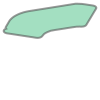

In [70]:
block_buffer

In [71]:
roads_buffer = 10
buildings_buffer = 10


In [51]:
@staticmethod
def dwn_other(block, local_crs) -> gpd.GeoSeries:
    '''download other'''
    try:
        other = ox.geometries_from_polygon(block, tags={"man_made": True, "aeroway": True,"military": True })
        other['geometry'] = other['geometry'].to_crs(local_crs)
        return other.geometry
    except:
        return gpd.GeoSeries()

@staticmethod
def dwn_leisure(block, local_crs) -> gpd.GeoSeries:
    try:
        leisure = ox.geometries_from_polygon(block, tags={"leisure": True})
        leisure['geometry'] = leisure['geometry'].to_crs(local_crs)
        return leisure.geometry
    except:
        return gpd.GeoSeries()

@staticmethod
def dwn_landuse(block, local_crs) -> gpd.GeoSeries:
    try:
        landuse = ox.geometries_from_polygon(block, tags={"landuse": True})
        if not landuse.empty:
            landuse = landuse[landuse['landuse'] != 'residential']
        landuse['geometry'] = landuse['geometry'].to_crs(local_crs)
        return landuse.geometry
    except:
        return gpd.GeoSeries()

@staticmethod
def dwn_amenity(block, local_crs) -> gpd.GeoSeries:
    try:
        amenity = ox.geometries_from_polygon(block, tags={"amenity": True})
        amenity['geometry'] = amenity['geometry'].to_crs(local_crs)
        return amenity.geometry
    except:
        return gpd.GeoSeries()

@staticmethod
def dwn_buildings(block, local_crs ,buildings_buffer) -> gpd.GeoSeries:
    try:
        buildings = ox.geometries_from_polygon(block, tags={"building": True})
        if buildings_buffer:
            buildings['geometry'] = buildings['geometry'].to_crs(local_crs).buffer(buildings_buffer)
        return buildings.geometry
    except:
        return gpd.GeoSeries()

@staticmethod
def dwn_natural(block, local_crs) -> gpd.GeoSeries:
    try:
        natural = ox.geometries_from_polygon(block, tags={"natural": True})
        if not natural.empty:
            natural = natural[natural['natural'] != 'bay']
        natural['geometry'] = natural['geometry'].to_crs(local_crs)
        return natural.geometry
    except:
        return gpd.GeoSeries()

@staticmethod
def dwn_waterway(block, local_crs) -> gpd.GeoSeries:
    try:
        waterway = ox.geometries_from_polygon(block, tags={"waterway": True})
        waterway['geometry'] = waterway['geometry'].to_crs(local_crs)
        return waterway.geometry
    except:
        return gpd.GeoSeries()

@staticmethod
def dwn_highway(block, local_crs, roads_buffer) -> gpd.GeoSeries:
    try:
        highway = ox.geometries_from_polygon(block, tags={"highway": True})
        condition = (highway['highway'] != 'path') & (highway['highway'] != 'footway') & (highway['highway'] != 'pedestrian')
        filtered_highway = highway[condition]
        if roads_buffer:
            filtered_highway['geometry'] = filtered_highway['geometry'].to_crs(local_crs).buffer(roads_buffer)
        filtered_highway['geometry'] = filtered_highway['geometry'].to_crs(local_crs).buffer(1)
        return filtered_highway.geometry
    except:
        return gpd.GeoSeries()

@staticmethod
def dwn_path(block, local_crs)-> gpd.GeoSeries:
    try:
        tags = {'highway': 'path', 'highway': 'footway'}
        path = ox.geometries_from_polygon(block, tags=tags)
        path['geometry'] = path['geometry'].to_crs(local_crs).buffer(0.5)
        return path.geometry
    except:
        return gpd.GeoSeries()

@staticmethod
def dwn_railway(block, local_crs) -> gpd.GeoSeries:
    try:
        railway = ox.geometries_from_polygon(block, tags={"railway": True})
        if not railway.empty:
            railway = railway[railway['railway'] != 'subway']
        railway['geometry'] = railway['geometry'].to_crs(local_crs)
        return railway.geometry
    except:
        return gpd.GeoSeries()

In [72]:

leisure = dwn_leisure(block_buffer, local_crs)
landuse = dwn_landuse(block_buffer, local_crs)
other  = dwn_other(block_buffer, local_crs)
amenity = dwn_amenity(block_buffer, local_crs)
buildings = dwn_buildings(block_buffer, local_crs, buildings_buffer)
natural = dwn_natural(block_buffer, local_crs)
waterway = dwn_waterway(block_buffer, local_crs)
highway = dwn_highway(block_buffer, local_crs, roads_buffer)
railway = dwn_railway(block_buffer, local_crs)
path = dwn_path(block_buffer, local_crs)

/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_5383/1659136284.py:14: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  leisure = ox.geometries_from_polygon(block, tags={"leisure": True})
/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_5383/1659136284.py:23: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  landuse = ox.geometries_from_polygon(block, tags={"landuse": True})
/var/folders/h8/0wmx2zx90bn60jw8zc1r4qjc0000gn/T/ipykernel_5383/1659136284.py:5: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed th

In [66]:
occupied_area = [leisure, other, landuse, amenity, buildings, natural, waterway, highway, railway, path]
occupied_area = pd.concat(occupied_area)
occupied_area = gpd.GeoDataFrame(geometry=gpd.GeoSeries(occupied_area))

block_buffer2 = gpd.GeoDataFrame(geometry=block_gdf.buffer(60))
polygon = occupied_area.geometry.geom_type == "Polygon"
multipolygon = occupied_area.geometry.geom_type == "MultiPolygon"
blocks_new1 = gpd.overlay(block_buffer2, occupied_area[polygon], how="difference")
blocks_new2 = gpd.overlay(blocks_new1, occupied_area[multipolygon], how="difference")
blocks_new3 = gpd.overlay(block_gdf, blocks_new2, how="intersection")
blocks_exploded = blocks_new3.explode(index_parts=True)
blocks_exploded.reset_index(drop=True,inplace=True)

In [64]:
blocks_new1.explore()

In [54]:
occupied_area[multipolygon]

,geometry


In [68]:
blocks_new3.explore()

ValueError: Location values cannot contain NaNs.

In [17]:
occupied_area = [leisure, other, landuse, amenity, buildings, natural, waterway, highway, railway, path]
occupied_area = pd.concat(occupied_area)
occupied_area = gpd.GeoDataFrame(geometry=gpd.GeoSeries(occupied_area))

In [65]:
occupied_area.explore()

In [16]:

block_buffer2 = gpd.GeoDataFrame(geometry=block_gdf.buffer(20))

In [17]:
block_buffer2.explore()

In [18]:
polygon = occupied_area.geometry.geom_type == "Polygon"
multipolygon = occupied_area.geometry.geom_type == "MultiPolygon"
blocks_new = gpd.overlay(block_buffer2, occupied_area[polygon], how="difference")
blocks_new = gpd.overlay(blocks_new, occupied_area[multipolygon], how="difference")
blocks_new = gpd.overlay(block_gdf, blocks_new, how="intersection")



In [19]:
blocks_exploded = blocks_new.explode(index_parts=True)
blocks_exploded.reset_index(drop=True,inplace=True)


In [33]:
len(blocks_exploded)

0

In [20]:

va_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(blocks_exploded.geometry))

In [21]:
va_gdf['area'] = va_gdf['geometry'].area
va_gdf

,geometry,area


In [22]:
va_gdf.explore()

ValueError: Location values cannot contain NaNs.

In [ ]:
va_filtered_area = blocks_exploded[blocks_exploded['geometry'].area >= 100]

In [ ]:
len(va_filtered_area)

0

In [ ]:
va_filtered_area.explore()

In [ ]:

# Создайте новый GeoDataFrame для хранения результата
result_gdf = va_filtered_area.copy()

# Функция для построения минимального охватывающего четырехугольника
def create_minimum_bounding_rectangle(polygon):
    return polygon.minimum_rotated_rectangle

# Функция для расчета площади полигона
def calculate_polygon_area(polygon):
    return polygon.area

area_attitude = 2.8
# Пройдитесь по каждому полигону
for index, row in result_gdf.iterrows():
    polygon = row['geometry']
    
    # Постройте минимальный охватывающий четырехугольник
    mbr = create_minimum_bounding_rectangle(polygon)
    
    # Рассчитайте площадь полигона и площадь охватывающего четырехугольника
    polygon_area = calculate_polygon_area(polygon)
    mbr_area = calculate_polygon_area(mbr)
    
    # Проверьте, если площадь полигона больше 3 раз площади охватывающего четырехугольника
    if polygon.area * area_attitude < mbr.area:
        # Удалите полигон из результирующего GeoDataFrame
        result_gdf.drop(index, inplace=True)

# Выведите результат или сохраните его в новый файл
len(result_gdf)

32

In [ ]:
result_gdf.explore()

In [ ]:
def buffer_and_union(row, buffer_distance=1):
    polygon = row['geometry']
    buffer_polygon = polygon.buffer(buffer_distance)
    return buffer_polygon

In [ ]:
result_gdf['buffered_geometry'] = result_gdf.apply(buffer_and_union, axis=1)


In [ ]:

unified_geometry = result_gdf['buffered_geometry'].unary_union

result_gdf2 = gpd.GeoDataFrame(geometry=[unified_geometry], crs=result_gdf.crs)


In [ ]:
result_gdf_exploded = result_gdf2.explode(index_parts=True)
result_gdf_exploded['area'] = result_gdf_exploded['geometry'].area
result_gdf_exploded.reset_index(drop=True,inplace=True)

,geometry,area
0,"POLYGON ((344971.632 6649842.027, 344971.708 6...",202.553994
1,"POLYGON ((344370.299 6649857.502, 344370.361 6...",293.395436
2,"POLYGON ((344744.975 6649874.707, 344744.972 6...",826.197952
3,"POLYGON ((344377.383 6649876.733, 344377.321 6...",208.420882
4,"POLYGON ((344908.653 6649910.671, 344908.719 6...",258.431080
5,"POLYGON ((344773.983 6649918.871, 344774.038 6...",211.634588
6,"POLYGON ((344884.958 6649917.442, 344884.968 6...",205.298167
7,"POLYGON ((344990.728 6650011.106, 344990.804 6...",164.789647
8,"POLYGON ((344843.685 6650001.938, 344843.411 6...",216.492167
9,"POLYGON ((344579.000 6650056.528, 344578.906 6...",803.753231


In [ ]:
result_gdf_exploded.explore()

In [ ]:
gdf = result_gdf_exploded
len(gdf)

26

In [ ]:
# Рассчитайте ширину и длину каждого полигона и создайте новый столбец 'width' и 'height'
gdf['width'] = gdf['geometry'].apply(lambda geom: geom.bounds[2] - geom.bounds[0])
gdf['height'] = gdf['geometry'].apply(lambda geom: geom.bounds[3] - geom.bounds[1])


threshold_ratio = 1 # Задайте ваш пороговый параметр

# Фильтруйте полигоны, оставляя только те, у которых отношение длины к ширине не больше порогового значения
# Фильтруйте полигоны, оставляя только те, у которых отношение длины к ширине и ширины к длине меньше порога
filtered_gdf_1 = gdf[(gdf['width'] / gdf['height'] <= threshold_ratio)]
filtered_gdf_2 = gdf[(gdf['height'] / gdf['width'] <= threshold_ratio)]

filtered_gdf = gdf[(gdf['width'] / gdf['height'] <= threshold_ratio) | (gdf['height'] / gdf['width'] <= threshold_ratio)]
# Теперь у вас есть новый GeoDataFrame (filtered
print(len(filtered_gdf_1))
print(len(filtered_gdf_2))
print(len(filtered_gdf))

10
16
26


In [156]:
filtered_gdf.explore()

## Основной код


In [34]:

block_gdf['geometry']=  block_gdf['geometry'].to_crs(epsg=4326)

In [35]:
coordinate = ','.join(map(str, [block_gdf.total_bounds[1], 
                                    block_gdf.total_bounds[0], 
                                    block_gdf.total_bounds[3], 
                                    block_gdf.total_bounds[2]]))
print(coordinate)

59.954561446460204,30.21227774893605,59.960786022840026,30.229907442387166


In [46]:
def dwn_leisure(coordinate, projection):
    '''
    :param city_name: name of city --> str
    :param projection: epsg code of city crs --> int
    :return: GeoDataFrame
    '''
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = f"""
    [out:json];
        (
            relation["leisure"]({coordinate});
            way["leisure"]({coordinate});
        );
        out geom;
    """
    result = None
    attempts = 0
    while result is None and attempts < 5:
        try:
            result = requests.get(overpass_url, params={'data': overpass_query}).json()
            resp = osm2geojson.json2geojson(result)
            leisure = gpd.GeoDataFrame.from_features(resp['features']).set_crs(4326).to_crs(projection)
            leisure = leisure.geometry
            print('Leisure objects downloaded')
            return leisure
        except:
            attempts += 1

    print('Failed to download leisure objects after 5 attempts')
    return None



In [50]:
leisure=dwn_leisure(coordinate, 32637)

Leisure objects downloaded


In [51]:
leisure.explore()

In [ ]:
def dwn_other(coordinate, projection):
    '''
    :param city_name: name of city --> str
    :param projection: epsg code of city crs --> int
    :return: GeoDataFrame
    '''
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = f"""
    [out:json];
            
        (
            relation["man_made"]({coordinate});
            way["man_made"]({coordinate});
            
            relation["aeroway"]({coordinate});
            way["aeroway"]({coordinate});

            way["military"]({coordinate});
            relation["military"]({coordinate});
        
        );
    out geom;
    """
    
    result = None
    attempts = 0
    while result is None and attempts < 5:
        try:
            result = requests.get(overpass_url, params={'data': overpass_query}).json()
            resp = osm2geojson.json2geojson(result)
            other = gpd.GeoDataFrame.from_features(resp['features']).set_crs(4326).to_crs(projection)
            other = other.geometry
            print('Other objects downloaded')
            return other
        except:
            attempts += 1

    print('Failed to download other objects after 5 attempts')
    return None



In [ ]:
other=dwn_other(coordinate, projection)

Other objects downloaded


In [ ]:
other

0    POLYGON ((-320742.352 6739020.545, -320725.733...
1    POLYGON ((-320558.240 6739051.883, -320551.740...
2    LINESTRING (-320766.884 6739464.509, -320802.0...
3    LINESTRING (-321004.458 6739517.851, -321020.3...
4    LINESTRING (-321236.294 6739315.329, -321208.7...
5    POLYGON ((-321061.927 6739371.823, -321056.151...
6    POLYGON ((-320768.543 6739484.124, -320769.365...
7    POLYGON ((-320840.894 6739501.111, -320836.695...
8    POLYGON ((-321054.787 6739401.959, -321070.852...
9    POLYGON ((-320573.697 6738832.649, -320570.665...
Name: geometry, dtype: geometry

In [ ]:
def dwn_landuse(coordinate, projection):
    '''
    :param city_name: name of city --> str
    :param projection: epsg code of city crs --> int
    :return: GeoDataFrame
    '''
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = f"""
    [out:json];
        (
        relation["landuse"]["landuse"!~"residential"]({coordinate});
        way["landuse"]["landuse"!~"residential"]({coordinate});
        );
    (._;);
    out geom;
    """

    result = None
    attempts = 0
    while result is None and attempts < 5:
        try:
            result = requests.get(overpass_url, params={'data': overpass_query}).json()
            resp = osm2geojson.json2geojson(result)
            landuse = gpd.GeoDataFrame.from_features(resp['features']).set_crs(4326).to_crs(projection)
            landuse = landuse.geometry
            print('Landuse objects downloaded')
            return landuse
        except:
            attempts += 1

    print('Failed to download landuse objects after 5 attempts')
    return None

 

In [ ]:
landuse=dwn_landuse(coordinate, projection)
landuse

Landuse objects downloaded


0      POLYGON ((-320187.663 6739288.972, -320180.118...
1      POLYGON ((-320165.663 6739283.870, -320166.871...
2      POLYGON ((-320244.397 6739234.234, -320245.044...
3      POLYGON ((-320537.707 6738792.839, -320630.824...
4      POLYGON ((-321341.524 6738932.317, -321341.391...
                             ...                        
113    POLYGON ((-320737.845 6738937.993, -320725.728...
114    POLYGON ((-320723.349 6739012.324, -320717.602...
115    POLYGON ((-320766.808 6738982.812, -320753.972...
116    POLYGON ((-320958.027 6738838.870, -320925.169...
117    MULTIPOLYGON (((-320328.280 6739209.465, -3203...
Name: geometry, Length: 118, dtype: geometry

In [ ]:
landuse.explore()

In [36]:
def dwn_amenity(coordinate, projection):
    '''
    :param city_name: name of city --> str
    :param projection: epsg code of city crs --> int
    :return: GeoDataFrame
    '''
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = f"""
    [out:json];
    (
        relation["amenity"]({coordinate});
        way["amenity"]({coordinate});
    );
    out geom;
    """
    result = None
    attempts = 0
    while result is None and attempts < 5:
        try:
            result = requests.get(overpass_url, params={'data': overpass_query}).json()
            resp = osm2geojson.json2geojson(result)
            amenity = gpd.GeoDataFrame.from_features(resp['features']).set_crs(4326).to_crs(projection)
            amenity = amenity.geometry
            print('Amenity objects downloaded')
            return amenity
        except:
            attempts += 1

    print('Failed to download amenity objects after 5 attempts')
    return None


In [37]:
amenity=dwn_amenity(coordinate_str, 32636)
amenity


Failed to download amenity objects after 5 attempts


In [ ]:
amenity.explore()

In [ ]:
def dwn_buildings(coordinate, projection):
    '''
    :param city_name: name of city --> str
    :param projection: epsg code of city crs --> int
    :return: GeoDataFrame
    '''
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = f"""
    [out:json];
        (
            relation["building"]({coordinate});
            way["building"]({coordinate});
        );
    out geom;
    """
    result = None
    attempts = 0
    while result is None and attempts < 5:
        try:
            result = requests.get(overpass_url, params={'data': overpass_query}).json()
            resp = osm2geojson.json2geojson(result)
            buildings = gpd.GeoDataFrame.from_features(resp['features']).set_crs(4326).to_crs(projection)
            buildings = buildings.geometry
            print('Buildings objects downloaded')
            return buildings
        except:
            attempts += 1

    print('Failed to download buildings objects after 5 attempts')
    return None

In [ ]:
buildings=dwn_buildings(coordinate, projection)
buildings

Buildings objects downloaded


0      POLYGON ((-320624.659 6738518.138, -320635.821...
1      POLYGON ((-320363.733 6738586.249, -320364.980...
2      POLYGON ((-320493.456 6738791.698, -320491.969...
3      POLYGON ((-320371.640 6738704.242, -320382.562...
4      POLYGON ((-320569.141 6738656.137, -320570.209...
                             ...                        
181    MULTIPOLYGON (((-321041.404 6738712.995, -3210...
182    MULTIPOLYGON (((-320895.792 6739162.558, -3209...
183    MULTIPOLYGON (((-320218.495 6739044.262, -3202...
184    MULTIPOLYGON (((-321134.301 6738700.077, -3211...
185    MULTIPOLYGON (((-320430.970 6738718.936, -3204...
Name: geometry, Length: 186, dtype: geometry

In [ ]:
buildings.explore()

In [ ]:
def dwn_natural(coordinate, projection):
    '''
    :param city_name: name of city --> str
    :param projection: epsg code of city crs --> int
    :return: GeoDataFrame
    '''
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = f"""
    [out:json];
    (
        way["natural"]({coordinate});
        relation["natural"]({coordinate});
    );      
    out geom;
    """
    result = None
    attempts = 0
    while result is None and attempts < 5:
        try:
            result = requests.get(overpass_url, params={'data': overpass_query}).json()
            resp = osm2geojson.json2geojson(result)
            natural = gpd.GeoDataFrame.from_features(resp['features']).set_crs(4326).to_crs(projection)
            natural = natural.geometry
            print('Natural objects downloaded')
            return natural
        except:
            attempts += 1

    print('Failed to download natural objects after 5 attempts')
    return None

In [ ]:
natural=dwn_natural(coordinate, projection)
natural

Natural objects downloaded


0     LINESTRING (-320168.573 6739365.375, -320208.6...
1     POLYGON ((-321580.132 6738708.496, -321543.138...
2     POLYGON ((-320307.046 6738781.673, -320264.585...
3     POLYGON ((-320315.870 6738735.395, -320320.417...
4     POLYGON ((-320329.690 6738792.830, -320316.612...
5     POLYGON ((-320498.242 6738633.709, -320500.682...
6     POLYGON ((-320373.797 6738657.766, -320372.691...
7     POLYGON ((-320395.279 6738645.059, -320392.238...
8     POLYGON ((-320367.553 6739268.440, -320379.018...
9     POLYGON ((-321246.701 6739294.359, -321246.899...
10    POLYGON ((-321167.508 6739220.479, -321175.475...
11    MULTIPOLYGON (((-321360.245 6738982.623, -3213...
Name: geometry, dtype: geometry

In [ ]:
natural.explore()

In [36]:

def dwn_waterway(coordinate, projection):
    '''
    :param city_name: name of city --> str
    :param projection: epsg code of city crs --> int
    :return: GeoDataFrame
    '''
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = f"""
    [out:json];
    (
        way["waterway"]({coordinate});
        relation["waterway"]({coordinate});
    ); 
    out geom;
    """
    result = None
    attempts = 0
    
    while result is None and attempts < 5:
        try:
            result = requests.get(overpass_url, params={'data': overpass_query}).json()
            resp = osm2geojson.json2geojson(result)
            waterway = gpd.GeoDataFrame.from_features(resp['features']).set_crs(4326).to_crs(projection)
            waterway = waterway.geometry
            print('Waterway objects downloaded')
            return waterway
        except:
            attempts += 1

    print('Failed to download waterway objects after 5 attempts')
    return None  # Возвращаем пустой GeoDataFrame, если не удалось получить данные




In [38]:
waterway=dwn_waterway(coordinate, 32637)
waterway

Failed to download waterway objects after 5 attempts


In [ ]:
def dwn_roads(coordinate, projection):
    '''
    :param city_name: name of targeted city --> str
    :param projection: epsg code of city crs --> int
    :return: GeoDataFrame
    '''
    overpass_url = "https://maps.mail.ru/osm/tools/overpass/api/interpreter"
    overpass_query = f"""
    [out:json];
    (      
            way["highway"]["highway"!~"path|footway|pedestrian"]({coordinate});
           
            way["railway"]["railway"!~"subway"]({coordinate});
        
    );
    (._;);
    out geom;
    """
    result = None
    attempts = 0
    
    while result is None and attempts < 5:
        try:
            result = requests.get(overpass_url, params={'data': overpass_query}).json()
            resp = osm2geojson.json2geojson(result)
            roads = gpd.GeoDataFrame.from_features(resp['features']).set_crs(4326).to_crs(projection)
            roads = roads.geometry
            print('Roads objects downloaded')
            return roads
        except:
            attempts += 1

    print('Failed to download roads objects after 5 attempts')
    return None  # Возвращаем пустой GeoDataFrame, если не удалось получить данные

In [ ]:
roads=dwn_roads(coordinate, projection)

Roads objects downloaded


In [ ]:
roads

0      LINESTRING (-320864.069 6738891.965, -320874.2...
1      LINESTRING (-321255.073 6739049.848, -321247.0...
2      LINESTRING (-320809.102 6738917.178, -320812.2...
3      LINESTRING (-320627.429 6738883.317, -320626.0...
4      LINESTRING (-321415.336 6738760.295, -321404.8...
                             ...                        
389    LINESTRING (-320167.979 6739298.243, -320156.9...
390    LINESTRING (-321027.182 6738790.303, -321033.7...
391    LINESTRING (-320974.774 6739196.266, -320994.5...
392    LINESTRING (-320995.364 6739160.345, -320976.8...
393    LINESTRING (-320976.824 6739150.731, -320974.7...
Name: geometry, Length: 394, dtype: geometry

In [ ]:
roads.explore()

In [ ]:
leisure=dwn_leisure(coordinate, projection)
other=dwn_other(coordinate, projection)
landuse=dwn_landuse(coordinate, projection)
amenity=dwn_amenity(coordinate, projection)
natural=dwn_natural(coordinate, projection)
waterway=dwn_waterway(coordinate, projection)
buildings=dwn_buildings(coordinate, projection)
roads=dwn_roads(coordinate, projection)

Leisure objects downloaded
Other objects downloaded
Landuse objects downloaded
Amenity objects downloaded
Natural objects downloaded
Buildings objects downloaded
Roads objects downloaded


In [ ]:
def free_area(city_name, projection, city_blocks_file):
    '''
    :param city_name: name of city --> str
    :param projection: epsg code of city crs --> int
    :param city_blocks_file: file with blocks of city. Attributes: id, geometry --> 'name.geojson' in root
    :return: GeoDataFrame with free space in the city
    '''
    blocks = gpd.read_file(city_blocks_file)
    blocks = gpd.GeoDataFrame.from_features(blocks).set_crs(4326).to_crs(projection)
    print('City blocks downloaded')

    leisure=dwn_leisure(coordinate, projection)
    other=dwn_other(coordinate, projection)
    landuse=dwn_landuse(coordinate, projection)
    amenity=dwn_amenity(coordinate, projection)
    natural=dwn_natural(coordinate, projection)
    waterway=dwn_waterway(coordinate, projection)
    buildings=dwn_buildings(coordinate, projection)
    roads=dwn_roads(coordinate, projection)

    
    occupied_area = [leisure, other, landuse, amenity, natural, waterway, buildings, roads]
    occupied_area = pd.concat(occupied_area)
    occupied_area = gpd.GeoDataFrame(geometry=gpd.GeoSeries(occupied_area))



    print('Clipping objects from blocks')

    polygon = occupied_area.geometry.geom_type == "Polygon"
    multipolygon = occupied_area.geometry.geom_type == "MultiPolygon"
    blocks_new = gpd.overlay(blocks, occupied_area[polygon], how="difference")
    blocks_new = gpd.overlay(blocks_new, occupied_area[multipolygon], how="difference")
    blocks_new = blocks_new.reset_index(drop=False).rename(columns={"index": "block_id"})

    print('Exploding multipolygons into polygons')

    blocks_exploded = gpd.GeoDataFrame(columns=blocks_new.columns)
    for index, row in blocks_new.iterrows():
        if row.geometry.geom_type == 'Polygon':
            blocks_exploded = blocks_exploded.append(row,ignore_index=True)
        if row.geometry.geom_type == 'MultiPolygon':
            multdf = gpd.GeoDataFrame(columns=blocks_new.columns)
            recs = len(row.geometry.geoms)
            multdf = multdf.append([row]*recs,ignore_index=True)
            for geom in range(recs):
                multdf.loc[geom, 'geometry'] = row.geometry[geom]
            blocks_exploded = blocks_exploded.append(multdf,ignore_index=True)
            
    blocks_exploded['max_empty_area']=blocks_exploded.area

    print('Finding max empty area')
    
    blocks_max = blocks_exploded.sort_values(['block_id', 'max_empty_area'], ascending=[True,False])
    blocks_max = blocks_max.drop_duplicates('block_id',keep='first').reset_index(drop=True)
    blocks_max = blocks_max.set_crs(projection).to_crs(4326)

    print('Ready')
    return blocks_max

In [ ]:
#here city name in OSM (can be in russian, can be in english), EPSG code of CRS, way to file with city blocks
free_area = free_area('Санкт-Петербург', 32638, '/home/max/jup/Data/Kvartal.geojson') 
free_area.to_file("SPB_free_area.geojson", driver='GeoJSON')

DriverError: /home/max/jup/Data/Kvartal.geojson: No such file or directory

: 

: 

: 

: 

In [32]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
from typing import ClassVar

from pydantic import BaseModel
from ...models import CityModel


class VacantArea(BaseModel):

    city_model: CityModel
 
    local_crs: ClassVar[int] = 32636
    roads_buffer: ClassVar[int] = 10
    buildings_buffer: ClassVar[int] = 10

    @classmethod
    def dwn_other(cls, block, local_crs):
        other = ox.geometries_from_polygon(block, tags={"man_made": True, "aeroway": True,"military": True })
        other['geometry'] = other['geometry'].to_crs(local_crs)
        return other.geometry
    
    @classmethod
    def dwn_leisure(cls, block, local_crs):
        leisure = ox.geometries_from_polygon(block, tags={"leisure": True})
        leisure['geometry'] = leisure['geometry'].to_crs(local_crs)
        return leisure.geometry
    
    @classmethod
    def dwn_landuse(cls,block, local_crs):
        landuse = ox.geometries_from_polygon(block, tags={"landuse": True})
        if not landuse.empty:
            landuse = landuse[landuse['landuse'] != 'residential']
        landuse['geometry'] = landuse['geometry'].to_crs(local_crs)
        return landuse.geometry
    
    @classmethod
    def dwn_amenity(cls,block, local_crs):
        amenity = ox.geometries_from_polygon(block, tags={"amenity": True})
        amenity['geometry'] = amenity['geometry'].to_crs(local_crs)
        return amenity.geometry
    
    @classmethod
    def dwn_buildings(cls,block, local_crs ,buildings_buffer):
        buildings = ox.geometries_from_polygon(block, tags={"building": True})
        if buildings_buffer:
            buildings['geometry'] = buildings['geometry'].to_crs(local_crs).buffer(buildings_buffer)
        return buildings.geometry
    
    @classmethod
    def dwn_natural(cls,block, local_crs):
        natural = ox.geometries_from_polygon(block, tags={"natural": True})
        if not natural.empty:
            natural = natural[natural['natural'] != 'bay']
        natural['geometry'] = natural['geometry'].to_crs(local_crs)
        return natural.geometry
    
    @classmethod
    def dwn_waterway(cls,block, local_crs):
        waterway = ox.geometries_from_polygon(block, tags={"waterway": True})
        waterway['geometry'] = waterway['geometry'].to_crs(local_crs)
        return waterway.geometry
    
    @classmethod
    def dwn_highway(cls, block, local_crs, roads_buffer):
        highway = ox.geometries_from_polygon(block, tags={"highway": True})
        condition = (highway['highway'] != 'path') & (highway['highway'] != 'footway') & (highway['highway'] != 'pedestrian')
        filtered_highway = highway[condition]
        if roads_buffer:
            filtered_highway['geometry'] = filtered_highway['geometry'].to_crs(local_crs).buffer(roads_buffer)
        filtered_highway['geometry'] = filtered_highway['geometry'].to_crs(local_crs).buffer(1)
        return filtered_highway.geometry
    
    @classmethod
    def dwn_path(cls, block, local_crs):
        tags = {'highway': 'path', 'highway': 'footway'}
        path = ox.geometries_from_polygon(block, tags=tags)
        path['geometry'] = path['geometry'].to_crs(local_crs).buffer(0.5)
        return path.geometry
    
    @classmethod
    def dwn_railway(cls, block, local_crs):
        railway = ox.geometries_from_polygon(block, tags={"railway": True})
        if not railway.empty:
            railway = railway[railway['railway'] != 'subway']
        railway['geometry'] = railway['geometry'].to_crs(local_crs)
        return railway.geometry
    
    @classmethod
    def create_minimum_bounding_rectangle(cls, polygon):
        return polygon.minimum_rotated_rectangle
    
    @classmethod
    def buffer_and_union(cls, row, buffer_distance=1):
        polygon = row['geometry']
        buffer_polygon = polygon.buffer(buffer_distance)
        return buffer_polygon
    
    def get_vacant_area(self, blpck_id:int):
  
        blocks= self.city_model.blocks.to_gdf().copy()
        blocks = gpd.GeoDataFrame(geometry=gpd.GeoSeries(blocks.geometry))
        if blpck_id:
            block_gdf = gpd.GeoDataFrame([blocks.iloc[blpck_id]], crs=blocks.crs)
            block_buffer = block_gdf['geometry'].buffer(20).to_crs(epsg=4326).iloc[0]
        else:
            block_gdf = blocks
            block_buffer = blocks.buffer(20).to_crs(epsg=4326).unary_union

        leisure = self.dwn_leisure(block_buffer, self.local_crs)
        landuse = self.dwn_landuse(block_buffer, self.local_crs)
        other  = self.dwn_other(block_buffer, self.local_crs)
        amenity = self.dwn_amenity(block_buffer, self.local_crs)
        buildings = self.dwn_buildings(block_buffer, self.local_crs, self.buildings_buffer)
        natural = self.dwn_natural(block_buffer, self.local_crs)
        waterway = self.dwn_waterway(block_buffer, self.local_crs)
        highway = self.dwn_highway(block_buffer, self.local_crs, self.roads_buffer)
        railway = self.dwn_railway(block_buffer, self.local_crs)
        path = self.dwn_path(block_buffer, self.local_crs)

        occupied_area = [leisure, other, landuse, amenity, buildings, natural, waterway, highway, railway, path]
        occupied_area = pd.concat(occupied_area)
        occupied_area = gpd.GeoDataFrame(geometry=gpd.GeoSeries(occupied_area))

        block_buffer2 = gpd.GeoDataFrame(geometry=block_gdf.buffer(20))
        polygon = occupied_area.geometry.geom_type == "Polygon"
        multipolygon = occupied_area.geometry.geom_type == "MultiPolygon"
        blocks_new = gpd.overlay(block_buffer2, occupied_area[polygon], how="difference")
        blocks_new = gpd.overlay(blocks_new, occupied_area[multipolygon], how="difference")
        blocks_new = gpd.overlay(block_gdf, blocks_new, how="intersection")
        blocks_exploded = blocks_new.explode(index_parts=True)
        blocks_exploded.reset_index(drop=True,inplace=True)

        blocks_filtered_area = blocks_exploded[blocks_exploded['geometry'].area >= 100] #1
        if blocks_filtered_area.empty:
            print('The block has no vacant area')
            return  None
        
        area_attitude = 1.9 # 2
        for index, row in blocks_filtered_area.iterrows():
            polygon = row['geometry']
            mbr = self.create_minimum_bounding_rectangle(polygon)
            if polygon.area * area_attitude < mbr.area:
                blocks_filtered_area.drop(index, inplace=True)

        blocks_filtered_area['buffered_geometry'] = blocks_filtered_area.apply(self.buffer_and_union, axis=1)
        unified_geometry = blocks_filtered_area['buffered_geometry'].unary_union

        result_gdf = gpd.GeoDataFrame(geometry=[unified_geometry], crs=blocks_filtered_area.crs)
        result_gdf_exploded = result_gdf.explode(index_parts=True)
        result_gdf_exploded['area'] = result_gdf_exploded['geometry'].area
        result_gdf_exploded.reset_index(drop=True, inplace=True)
        return result_gdf_exploded

C:\Users\skitl\AppData\Local\Temp\ipykernel_1572\3706794407.py:7: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  from ...models import CityModel


ImportError: attempted relative import with no known parent package